In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def prepare_data(df, tokenizer):
    lyrics1 = df['Lyrics'].tolist()
    mood1 = df['Mood_encod'].tolist()

    train_inputs, val_inputs, train_labels, val_labels = train_test_split(
        lyrics1, mood1, test_size=0.2, random_state=42
    )

    train_encodings = tokenizer(train_inputs, padding=True, truncation=True, return_tensors="pt")
    val_encodings = tokenizer(val_inputs, padding=True, truncation=True, return_tensors="pt")

    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)

    train_data = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_data = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

    return train_data, val_data

In [4]:
def create_bert_model(model_name, num_classes):
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes,problem_type="multi_label_classification",
                                                          ignore_mismatched_sizes=True)
    return model

In [14]:
def train_bert_model(model, train_dataloader, val_dataloader, optimizer, loss, scheduler, device, epochs=10, accumulation_steps=4, checkpoint=1):
    scaler = GradScaler()

    T_loss = []
    V_loss = []
    T_acc = []
    V_acc = []
    T_f1 = []
    V_f1 = []

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0
        train_pred = []
        train_true = []

        for step, batch in enumerate(tqdm(train_dataloader)):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss_value = loss(logits, labels)

            scaler.scale(loss_value).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            prob = nn.functional.softmax(logits, dim=-1)
            pred = torch.argmax(prob, dim=-1)

            train_loss += loss_value.item()
            train_pred.extend(pred.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        scheduler.step()

        T_acc.append(accuracy_score(train_true, train_pred))
        T_f1.append(f1_score(train_true, train_pred, average='weighted'))
        T_loss.append(train_loss / len(train_dataloader))

        print("Epoch: {}, Training Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}"
              .format(epoch, train_loss / len(train_dataloader),
                      accuracy_score(train_true, train_pred),
                      f1_score(train_true, train_pred, average='weighted')))

        # Validation loop
        model.eval()
        val_loss = 0
        val_pred = []
        val_true = []

        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                prob = nn.functional.softmax(logits, dim=-1)
                pred = torch.argmax(prob, dim=-1)

                loss_value = loss(logits, labels)
                val_loss += loss_value.item()
                val_pred.extend(pred.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        V_acc.append(accuracy_score(val_true, val_pred))
        V_f1.append(f1_score(val_true, val_pred, average='weighted'))
        V_loss.append(val_loss / len(val_dataloader))

        print("Epoch: {}, Validation Loss: {:.4f}, Accuracy: {:.4f}, F1 Score: {:.4f}"
              .format(epoch, val_loss / len(val_dataloader),
                      accuracy_score(val_true, val_pred),
                      f1_score(val_true, val_pred, average='weighted')))

    return T_loss, V_loss, T_acc, V_acc, T_f1, V_f1


In [6]:
def plot_metrics(T_loss, V_loss, T_acc, V_acc, T_f1, V_f1):
    # Plotting all the metrics
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.plot(T_loss, label='Training Loss')
    plt.plot(V_loss, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(T_acc, label='Training Accuracy')
    plt.plot(V_acc, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(T_f1, label='Training F1 Score')
    plt.plot(V_f1, label='Validation F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
df.head()

,Index,Artist,Title,Mood,Check,Filename,Lyrics
0,ML100,Bad Company,Can't Get Enough,happy,Y,ML100_Cant Get Enough.txt,"[Intro]\n\n[Verse 1]\nWell, I take whatever I ..."
1,ML1003,Los Lobos,Come On Let's Go,happy,Y,ML1003_Come On Lets Go.txt,"[Verse 1]\nWell, come on let's go, let's go, l..."
2,ML1008,Hezekiah Walker & The Love Fellowship Crusade ...,Power Belongs To God,happy,Y,ML1008_Power Belongs To God.txt,\nTrust in the Lord at all times\nPour out you...
3,ML1009,Donald Byrd,Think Twice,happy,Y,ML1009_Think Twice.txt,\n[Verse 1: Kay Haith]\nMaybe we oughta think ...
4,ML1011,Inner City,Good Life,happy,Y,ML1011_Good Life.txt,[Verse 1]\n[Verse 1]\nLet me take you to a pla...


In [18]:
# Example usage
model_name = "textattack/bert-base-uncased-yelp-polarity"
tokenizer = BertTokenizer.from_pretrained(model_name)
df = pd.read_csv("/content/subset173_withLyrics_for_collab.csv")  # Your DataFrame with lyrics and mood
df['Mood_encod'] = df['Mood'].map({'happy': 0, 'sad': 1, 'angry': 2, 'relaxed': 3})
num_classes = len(set(df['Mood_encod']))
train_data, val_data = prepare_data(df, tokenizer)
model = create_bert_model(model_name, num_classes)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = lr_scheduler.StepLR(optimizer, 1.0, gamma=0.9)

100%|██████████| 18/18 [00:04<00:00,  3.72it/s]


Epoch: 0, Training Loss: 1.3154, Accuracy: 0.3043, F1 Score: 0.2257
Epoch: 0, Validation Loss: 1.4052, Accuracy: 0.2286, F1 Score: 0.1194


100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch: 1, Training Loss: 1.3321, Accuracy: 0.3188, F1 Score: 0.2182
Epoch: 1, Validation Loss: 1.4581, Accuracy: 0.2000, F1 Score: 0.0718


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch: 2, Training Loss: 1.2948, Accuracy: 0.3261, F1 Score: 0.2465
Epoch: 2, Validation Loss: 1.3611, Accuracy: 0.3143, F1 Score: 0.2604


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch: 3, Training Loss: 1.2585, Accuracy: 0.3551, F1 Score: 0.3126
Epoch: 3, Validation Loss: 1.2414, Accuracy: 0.3429, F1 Score: 0.3120


100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch: 4, Training Loss: 1.2224, Accuracy: 0.4058, F1 Score: 0.3913
Epoch: 4, Validation Loss: 1.2272, Accuracy: 0.3714, F1 Score: 0.3600


100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch: 5, Training Loss: 1.1874, Accuracy: 0.4420, F1 Score: 0.4310
Epoch: 5, Validation Loss: 1.1964, Accuracy: 0.4000, F1 Score: 0.4004


100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch: 6, Training Loss: 1.1969, Accuracy: 0.3551, F1 Score: 0.3161
Epoch: 6, Validation Loss: 1.1813, Accuracy: 0.4000, F1 Score: 0.3987


100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch: 7, Training Loss: 1.1735, Accuracy: 0.4855, F1 Score: 0.4610
Epoch: 7, Validation Loss: 1.1805, Accuracy: 0.3714, F1 Score: 0.3811


100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch: 8, Training Loss: 1.1455, Accuracy: 0.4493, F1 Score: 0.4319
Epoch: 8, Validation Loss: 1.1498, Accuracy: 0.3714, F1 Score: 0.3743


100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch: 9, Training Loss: 1.1088, Accuracy: 0.5217, F1 Score: 0.5073
Epoch: 9, Validation Loss: 1.1174, Accuracy: 0.3714, F1 Score: 0.3821


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch: 10, Training Loss: 1.1019, Accuracy: 0.5435, F1 Score: 0.5322
Epoch: 10, Validation Loss: 1.1339, Accuracy: 0.3714, F1 Score: 0.3773


100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch: 11, Training Loss: 1.0808, Accuracy: 0.5435, F1 Score: 0.5271
Epoch: 11, Validation Loss: 1.1668, Accuracy: 0.3429, F1 Score: 0.3425


100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch: 12, Training Loss: 1.0428, Accuracy: 0.5290, F1 Score: 0.5040
Epoch: 12, Validation Loss: 1.1140, Accuracy: 0.4000, F1 Score: 0.4032


100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch: 13, Training Loss: 0.9925, Accuracy: 0.5652, F1 Score: 0.5410
Epoch: 13, Validation Loss: 1.0401, Accuracy: 0.4286, F1 Score: 0.4440


100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch: 14, Training Loss: 1.0227, Accuracy: 0.5652, F1 Score: 0.5361
Epoch: 14, Validation Loss: 1.0688, Accuracy: 0.4857, F1 Score: 0.4965


100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch: 15, Training Loss: 0.9823, Accuracy: 0.6014, F1 Score: 0.5853
Epoch: 15, Validation Loss: 1.0302, Accuracy: 0.4571, F1 Score: 0.4771


100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch: 16, Training Loss: 0.9758, Accuracy: 0.6232, F1 Score: 0.6088
Epoch: 16, Validation Loss: 1.1211, Accuracy: 0.4571, F1 Score: 0.4786


100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch: 17, Training Loss: 1.0224, Accuracy: 0.6014, F1 Score: 0.5822
Epoch: 17, Validation Loss: 1.0478, Accuracy: 0.4857, F1 Score: 0.5063


100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch: 18, Training Loss: 0.9719, Accuracy: 0.5870, F1 Score: 0.5677
Epoch: 18, Validation Loss: 1.0353, Accuracy: 0.4571, F1 Score: 0.4710


100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch: 19, Training Loss: 0.9401, Accuracy: 0.5942, F1 Score: 0.5772
Epoch: 19, Validation Loss: 1.1011, Accuracy: 0.4571, F1 Score: 0.4710


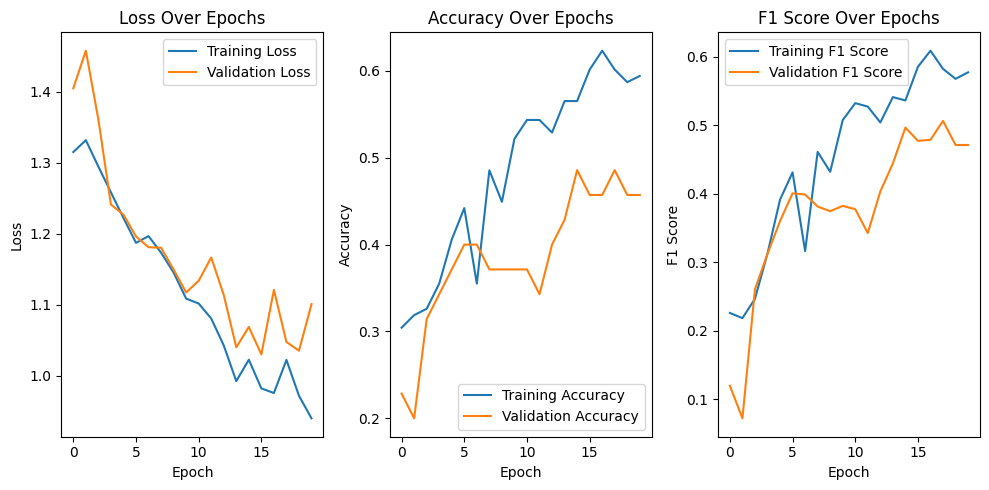

In [20]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T_loss, V_loss, T_acc, V_acc, T_f1, V_f1 = train_bert_model(model, train_dataloader, val_dataloader, optimizer, loss, scheduler, device, epochs=20)
plot_metrics(T_loss, V_loss, T_acc, V_acc, T_f1, V_f1)